Different Approach - Target CloseToWater Yes/No

## 1. Motivation and goals

As a beginner pokemon-go player I struggled with the randomness of pokemon sightings. I believe using historical data 
I can reveal a pattern or set of optimal factors.

## 2. Data Understanding

**Available at:** <br/> https://www.kaggle.com/semioniy/predictemall <br/> <br/>
**Datasets: ** <br/>  Dataset consists of roughly 293,000 pokemon sightings (historical appearances of Pokemon), having coordinates, time, weather, population density, distance to pokestops/ gyms etc. as features. The target is to train a machine learning algorithm so that it can predict where pokemon appear in future. So, can you predict'em all?) <br/> <br/>
**Feature description: ** <br/>

**pokemonId** - the identifier of a pokemon, should be deleted to not affect predictions. (numeric; ranges between 1 and 151) <br/>
**latitude, longitude** - coordinates of a sighting (numeric)<br/>
**appearedLocalTime** - exact time of a sighting in format yyyy-mm-dd'T'hh-mm-ss.ms'Z' (nominal)<br/>
**cellId 90-5850m** - geographic position projected on a S2 Cell, with cell sizes ranging from 90 to 5850m (numeric)<br/>
**appearedTimeOfDay** - time of the day of a sighting (night, evening, afternoon, morning)<br/>
**appearedHour/appearedMinute** - local hour/minute of a sighting (numeric)<br/>
**appearedDayOfWeek** - week day of a sighting (Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday)<br/>
**appearedDay/appearedMonth/appearedYear** - day/month/year of a sighting (numeric)<br/>
**terrainType** - terrain where pokemon appeared described with help of GLCF Modis Land Cover (numeric)<br/>
**closeToWater** - did pokemon appear close (100m or less) to water (Boolean, same source as above)<br/>
**city** - the city of a sighting (nominal)<br/>
**continent (not always parsed right)** - the continent of a sighting (nominal)<br/>
**weather** - weather type during a sighting (Foggy Clear, PartlyCloudy, MostlyCloudy, Overcast, Rain, BreezyandOvercast, LightRain, Drizzle, BreezyandPartlyCloudy, HeavyRain, BreezyandMostlyCloudy, Breezy, Windy, WindyandFoggy, Humid, Dry, WindyandPartlyCloudy, DryandMostlyCloudy, DryandPartlyCloudy, DrizzleandBreezy, LightRainandBreezy, HumidandPartlyCloudy, HumidandOvercast, RainandWindy) // Source for all weather features <br/>
**temperature** - temperature in celsius at the location of a sighting (numeric)<br/>
**windSpeed** - speed of the wind in km/h at the location of a sighting (numeric)<br/>
**windBearing** - wind direction (numeric)<br/>
**pressure** - atmospheric pressure in bar at the location of a sighting (numeric)<br/>
**weatherIcon** - a compact representation of the weather at the location of a sighting (fog, clear-night, partly-cloudy-night, partly-cloudy-day, cloudy, clear-day, rain, wind)<br/>
**sunriseMinutesMidnight-sunsetMinutesBefore** - time of appearance relatively to sunrise/sunset Source <br/>
**population density** - what is the population density per square km of a sighting (numeric, Source) <br/>
**urban-rural** - how urban is location where pokemon appeared (Boolean, built on Population density, <200 for rural, >=200 and <400 for midUrban, >=400 and <800 for subUrban, >800 for urban) <br/>
**gymDistanceKm, pokestopDistanceKm** - how far is the nearest gym/pokestop in km from a sighting? (numeric, extracted from this dataset) <br/>
**gymIn100m-pokestopIn5000m** - is there a gym/pokestop in 100/200/etc meters? (Boolean) <br/>
**cooc 1-cooc 151** - co-occurrence with any other pokemon (pokemon ids range between 1 and 151) within 100m distance and within the last 24 hours (Boolean) <br/>
**class** - says which pokemonId it is, to be predicted.

In [57]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.model_selection import train_test_split
# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [3]:
# Read file
file = pd.read_csv("300k.csv", dtype = 'unicode')

# Include second data source adding real pokemon names

pnames = pd.read_csv('pokemonNumbers.csv', names = ['pokemonId', 'pokemon_name'], dtype=object)
pd.set_option('display.max_columns', 300)
df = pd.DataFrame(file)
df2 = pd.merge(df, pnames, how='left', on = "pokemonId")

In [4]:
df2.head()

,pokemonId,latitude,longitude,appearedLocalTime,_id,cellId_90m,cellId_180m,cellId_370m,cellId_730m,cellId_1460m,cellId_2920m,cellId_5850m,appearedTimeOfDay,appearedHour,appearedMinute,appearedDayOfWeek,appearedDay,appearedMonth,appearedYear,terrainType,closeToWater,city,continent,weather,temperature,windSpeed,windBearing,pressure,weatherIcon,sunriseMinutesMidnight,sunriseHour,sunriseMinute,sunriseMinutesSince,sunsetMinutesMidnight,sunsetHour,sunsetMinute,sunsetMinutesBefore,population_density,urban,suburban,midurban,rural,gymDistanceKm,gymIn100m,gymIn250m,gymIn500m,gymIn1000m,gymIn2500m,gymIn5000m,pokestopDistanceKm,pokestopIn100m,pokestopIn250m,pokestopIn500m,pokestopIn1000m,pokestopIn2500m,pokestopIn5000m,cooc_1,cooc_2,cooc_3,cooc_4,cooc_5,cooc_6,cooc_7,cooc_8,cooc_9,cooc_10,cooc_11,cooc_12,cooc_13,cooc_14,cooc_15,cooc_16,cooc_17,cooc_18,cooc_19,cooc_20,cooc_21,cooc_22,cooc_23,cooc_24,cooc_25,cooc_26,cooc_27,cooc_28,cooc_29,cooc_30,cooc_31,cooc_32,cooc_33,cooc_34,cooc_35,cooc_36,cooc_37,cooc_38,cooc_39,cooc_40,cooc_41,cooc_42,cooc_43,cooc_44,cooc_45,cooc_46,cooc_47,cooc_48,cooc_49,cooc_50,cooc_51,cooc_52,cooc_53,cooc_54,cooc_55,cooc_56,cooc_57,cooc_58,cooc_59,cooc_60,cooc_61,cooc_62,cooc_63,cooc_64,cooc_65,cooc_66,cooc_67,cooc_68,cooc_69,cooc_70,cooc_71,cooc_72,cooc_73,cooc_74,cooc_75,cooc_76,cooc_77,cooc_78,cooc_79,cooc_80,cooc_81,cooc_82,cooc_83,cooc_84,cooc_85,cooc_86,cooc_87,cooc_88,cooc_89,cooc_90,cooc_91,cooc_92,cooc_93,cooc_94,cooc_95,cooc_96,cooc_97,cooc_98,cooc_99,cooc_100,cooc_101,cooc_102,cooc_103,cooc_104,cooc_105,cooc_106,cooc_107,cooc_108,cooc_109,cooc_110,cooc_111,cooc_112,cooc_113,cooc_114,cooc_115,cooc_116,cooc_117,cooc_118,cooc_119,cooc_120,cooc_121,cooc_122,cooc_123,cooc_124,cooc_125,cooc_126,cooc_127,cooc_128,cooc_129,cooc_130,cooc_131,cooc_132,cooc_133,cooc_134,cooc_135,cooc_136,cooc_137,cooc_138,cooc_139,cooc_140,cooc_141,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151,class,pokemon_name
0,16,20.525745,-97.460829,2016-09-08T03:57:45,NTgxMDkzOTk4MTM5MjUwMjIzNw==,9645139108510564000,9645139108711890000,9645139108443455000,9645139109517197000,9645139113812165000,9645139130992034000,9645138924833604000,night,5,57,dummy_day,8,8,2016,14,false,Mexico_City,America,Foggy,25.5,4.79,269,1018.02,fog,436,7,16,941,1181,19,41,-196,2431.2341,true,true,true,false,0.049869,true,true,true,true,true,true,0.081776,true,true,true,true,true,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,16,Pidgey
1,133,20.523695,-97.461167,2016-09-08T03:57:37,OTQ1NDgzODc1MjM3NDEzMTI2MQ==,9645139109852742000,9645139109785633000,9645139110590940000,9645139109517197000,9645139113812165000,9645139130992034000,9645138924833604000,night,5,57,dummy_day,8,8,2016,14,false,Mexico_City,America,Foggy,25.5,4.79,269,1018.02,fog,436,7,16,941,1181,19,41,-196,2431.2341,true,true,true,false,0.259156,false,false,true,true,true,true,0.195622,false,true,true,true,true,true,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,f

In [5]:
#limit dataframe to couple of features
df3 = df2[['pokemonId','pokemon_name','continent','city', 'appearedLocalTime', 'terrainType',
'closeToWater', 'weather', 'temperature', 'windSpeed', 'pressure', 'population_density', 'gymDistanceKm','pokestopDistanceKm']]
df3.shape
df3.head()

,pokemonId,pokemon_name,continent,city,appearedLocalTime,terrainType,closeToWater,weather,temperature,windSpeed,pressure,population_density,gymDistanceKm,pokestopDistanceKm
0,16,Pidgey,America,Mexico_City,2016-09-08T03:57:45,14,false,Foggy,25.5,4.79,1018.02,2431.2341,0.049869,0.081776
1,133,Eevee,America,Mexico_City,2016-09-08T03:57:37,14,false,Foggy,25.5,4.79,1018.02,2431.2341,0.259156,0.195622
2,16,Pidgey,America,New_York,2016-09-08T03:57:25,13,false,Clear,24.2,4.29,1015.29,761.8856,0.489886,0.338602
3,13,Weedle,America,Los_Angeles,2016-09-08T03:56:22,0,true,PartlyCloudy,15.6,5.84,1020.52,4842.1626,0.359309,0.109479
4,133,Eevee,America,Los_Angeles,2016-09-08T03:56:08,0,true,PartlyCloudy,15.6,5.84,1020.52,4842.1626,0.210543,0.040364


In [7]:
#What continents are available?
print("Continent")
df3.continent.value_counts().sort_index()

Continent


Africa                  104
America              150545
America/Argentina      1103
America/Indiana        1049
America/Kentucky         14
Asia                  15617
Atlantic                 36
Australia              3413
Europe               122145
Indian                    3
Pacific                1992
Name: continent, dtype: int64

In [8]:
# See terrain types
print( "TerrainType")
df3.terrainType.value_counts().sort_index()

TerrainType


0      18387
1       3525
10     12239
11        57
12     39085
13    129458
14     36189
16       212
2       1398
4       3052
5      31158
7       9977
8      11110
9        174
Name: terrainType, dtype: int64

In [9]:
#Weather
print ("Weather")
df3.weather.value_counts().sort_index()

Weather


Breezy                      983
BreezyandMostlyCloudy        72
BreezyandOvercast           230
BreezyandPartlyCloudy       534
Clear                    170482
DangerouslyWindy             89
Drizzle                    4237
DrizzleandBreezy            160
Dry                         897
DryandMostlyCloudy           55
DryandPartlyCloudy           77
Foggy                      1291
HeavyRain                   352
Humid                       609
HumidandOvercast            355
HumidandPartlyCloudy         16
LightRain                  4488
LightRainandBreezy           78
MostlyCloudy              46589
Overcast                  14419
PartlyCloudy              48349
Rain                       1335
RainandWindy                 41
Windy                       210
WindyandFoggy                68
WindyandPartlyCloudy          5
Name: weather, dtype: int64

In [10]:
#pokemons appeared close to water
print ("Close to water")
df3.closeToWater.value_counts().sort_index()

Close to water


false    227522
true      68499
Name: closeToWater, dtype: int64

In [11]:
df3.describe()

,pokemonId,pokemon_name,continent,city,appearedLocalTime,terrainType,closeToWater,weather,temperature,windSpeed,pressure,population_density,gymDistanceKm,pokestopDistanceKm
count,296021,296021,296021,296021,296021,296021,296021,296021,296021,296021,296021,296021,296021,296021
unique,144,144,11,98,196453,14,2,26,336,1760,2409,191,133598,124706
top,16,Pidgey,America,New_York,2016-09-06T14:56:22,13,false,Clear,25.6,3,1015.26,0,0.970566,1.109609
freq,52114,52114,150545,54177,146,129458,227522,170482,3975,4163,1023,17921,59,59


## 3. Data Wrangling

### 3.1 Data Cleaning

In [13]:
# assigning correct datatype
gymDistanceKm = df3['gymDistanceKm'].astype(float)
temp = df3.temperature.astype(float)
wind = df3.windSpeed.astype(float)
pressure = df3.pressure.astype(float)
pokemon_id = df3['pokemonId']
closetowater = df3['closeToWater'] == "true"
closetowater = closetowater.astype(int)

In [14]:
#dropping string values in a column that should be float
pokestop = pd.to_numeric(df3['pokestopDistanceKm'], errors='coerce')
pokestop.dtype

dtype('float64')

### 3.2 Numerical Features

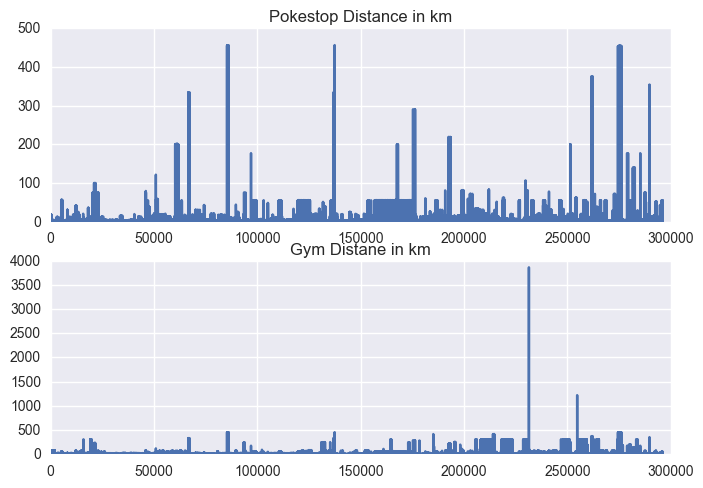

In [15]:
#Analyzing distance to next Pokestop and Gym
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_title("Pokestop Distance in km")
ax1.plot(pokestop)

ax2 = fig.add_subplot(212)
ax2.set_title("Gym Distane in km")
ax2.plot(gymDistanceKm)
plt.show()

In [16]:
pokestop.describe()

count    295982.000000
mean          0.695836
std           6.855852
min           0.000244
25%           0.066350
50%           0.156250
75%           0.367004
max         455.961075
Name: pokestopDistanceKm, dtype: float64

In [17]:
gymDistanceKm.describe()

count    296021.000000
mean          2.149072
std          18.646146
min           0.000591
25%           0.183422
50%           0.334473
75%           0.636140
max        3859.424664
Name: gymDistanceKm, dtype: float64

### 3.3 Categorical Features

In [18]:
df3.groupby(closetowater).count()

,pokemonId,pokemon_name,continent,city,appearedLocalTime,terrainType,closeToWater,weather,temperature,windSpeed,pressure,population_density,gymDistanceKm,pokestopDistanceKm
closeToWater,,,,,,,,,,,,,,
0,227522,227522,227522,227522,227522,227522,227522,227522,227522,227522,227522,227522,227522,227522
1,68499,68499,68499,68499,68499,68499,68499,68499,68499,68499,68499,68499,68499,68499


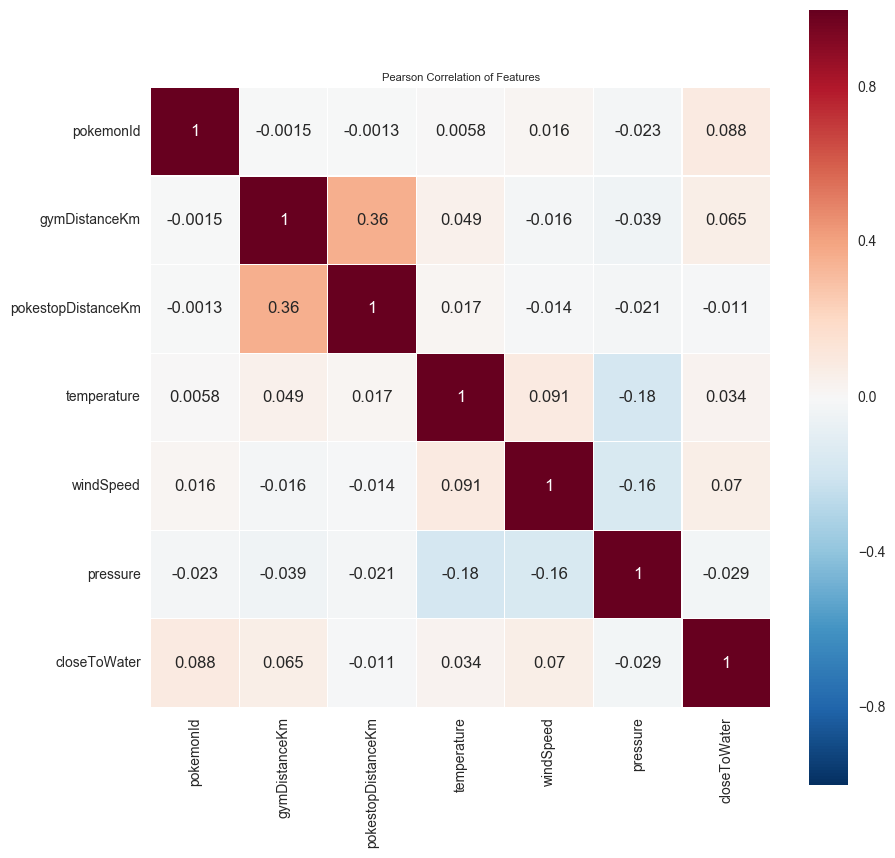

In [23]:
# Pearson Correlation Heatmap
df4 = pd.concat([ pokemon_id, gymDistanceKm, pokestop, temp, wind, pressure, closetowater], axis = 1)
colormap = plt.cm.cubehelix
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1, size=8)
sns.heatmap(df4.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)
plt.show()

From the above graph we can see correlation between pressure, windspeed and temperature. Pokestop distance is also highly correlted with distance to the gym.

In [24]:
# Create a new variable for every unique value of Terrain Type
terrain = pd.get_dummies( df3.terrainType , prefix='Terrain' )
terrain.head()

,Terrain_0,Terrain_1,Terrain_10,Terrain_11,Terrain_12,Terrain_13,Terrain_14,Terrain_16,Terrain_2,Terrain_4,Terrain_5,Terrain_7,Terrain_8,Terrain_9
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
pname = pd.get_dummies( df3.pokemon_name , prefix='pname' )
pname.head()

,pname_Abra,pname_Aerodactyl,pname_Alakazam,pname_Arbok,pname_Arcanine,pname_Beedrill,pname_Bellsprout,pname_Blastoise,pname_Bulbasaur,pname_Butterfree,pname_Caterpie,pname_Chansey,pname_Charizard,pname_Charmander,pname_Charmeleon,pname_Clefable,pname_Clefairy,pname_Cloyster,pname_Cubone,pname_Dewgong,pname_Diglett,pname_Dodrio,pname_Doduo,pname_Dragonair,pname_Dragonite,pname_Dratini,pname_Drowzee,pname_Dugtrio,pname_Eevee,pname_Ekans,pname_Electabuzz,pname_Electrode,pname_Exeggcute,pname_Exeggutor,pname_Farfetch'd,pname_Fearow,pname_Flareon,pname_Gastly,pname_Gengar,pname_Geodude,pname_Gloom,pname_Golbat,pname_Goldeen,pname_Golduck,pname_Golem,pname_Graveler,pname_Grimer,pname_Growlithe,pname_Gyarados,pname_Haunter,pname_Hitmonchan,pname_Hitmonlee,pname_Horsea,pname_Hypno,pname_Ivysaur,pname_Jigglypuff,pname_Jolteon,pname_Jynx,pname_Kabuto,pname_Kabutops,pname_Kadabra,pname_Kakuna,pname_Kangaskhan,pname_Kingler,pname_Koffing,pname_Krabby,pname_Lapras,pname_Lickitung,pname_Machoke,pname_Machop,pname_Magikarp,pname_Magmar,pname_Magnemite,pname_Magneton,pname_Mankey,pname_Marowak,pname_Meowth,pname_Metapod,pname_Mr. Mime,pname_Muk,pname_Nidoking,pname_Nidoqueen,pname_Nidoran F,pname_Nidoran M,pname_Nidorina,pname_Nidorino,pname_Ninetales,pname_Oddish,pname_Omanyte,pname_Omastar,pname_Onix,pname_Paras,pname_Parasect,pname_Persian,pname_Pidgeot,pname_Pidgeotto,pname_Pidgey,pname_Pikachu,pname_Pinsir,pname_Poliwag,pname_Poliwhirl,pname_Poliwrath,pname_Ponyta,pname_Porygon,pname_Primeape,pname_Psyduck,pname_Raichu,pname_Rapidash,pname_Raticate,pname_Rattata,pname_Rhydon,pname_Rhyhorn,pname_Sandshrew,pname_Sandslash,pname_Scyther,pname_Seadra,pname_Seaking,pname_Seel,pname_Shellder,pname_Slowbro,pname_Slowpoke,pname_Snorlax,pname_Spearow,pname_Squirtle,pname_Starmie,pname_Staryu,pname_Tangela,pname_Tauros,pname_Tentacool,pname_Tentacruel,pname_Vaporeon,pname_Venomoth,pname_Venonat,pname_Venusaur,pname_Victreebel,pname_Vileplume,pname_Voltorb,pname_Vulpix,pname_Wartortle,pname_Weedle,pname_Weepinbell,pname_Weezing,pname_Wigglytuff,pname_Zubat
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


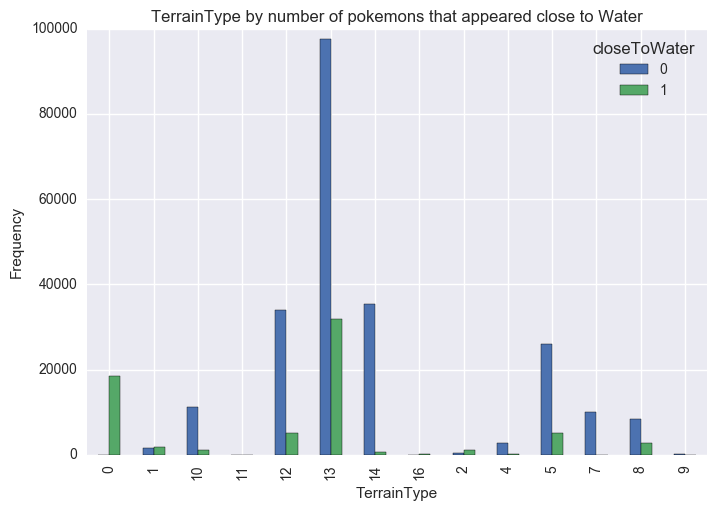

In [28]:
# Sightings splitted by terrain type. Coloured by information is it close to water or not

pd.crosstab(df3.terrainType, closetowater).plot(kind = 'bar')
plt.title('TerrainType by number of pokemons that appeared close to Water')
plt.xlabel('TerrainType')
plt.ylabel('Frequency')
plt.show()

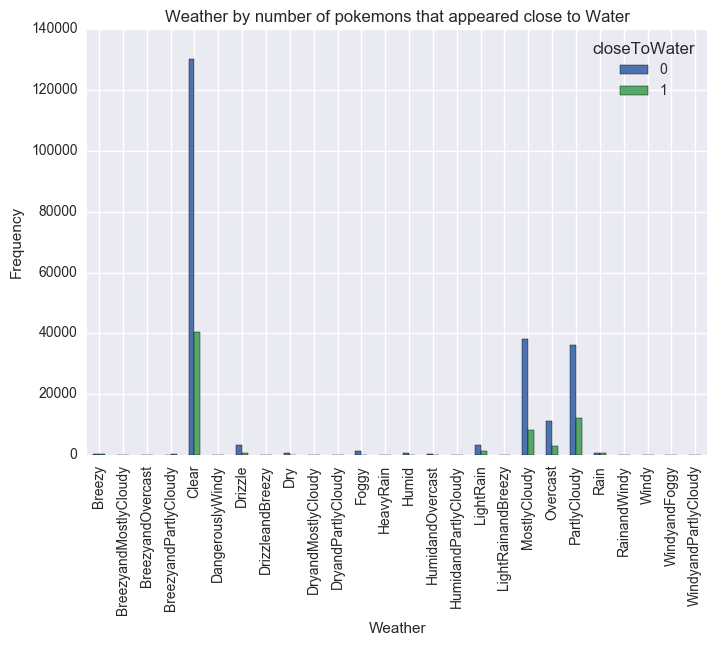

In [29]:
pd.crosstab(df3.weather, closetowater).plot(kind = 'bar')
plt.title('Weather by number of pokemons that appeared close to Water')
plt.xlabel('Weather')
plt.ylabel('Frequency')
plt.show()

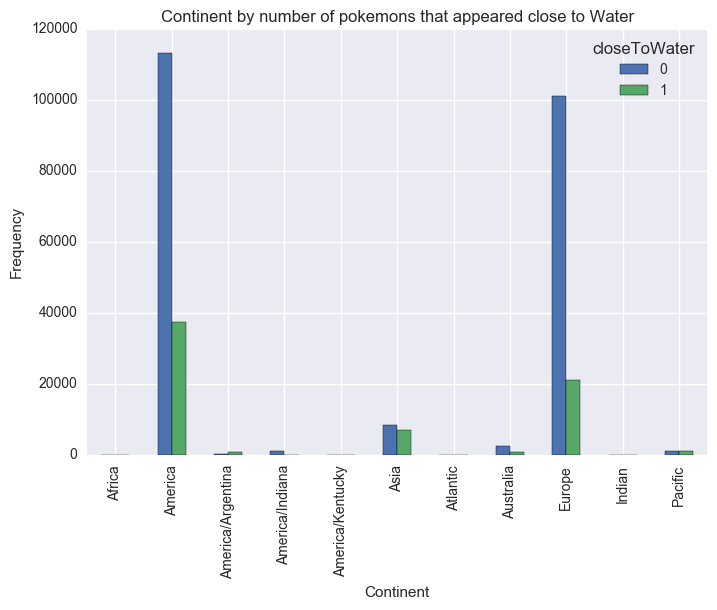

In [30]:
pd.crosstab(df3.continent, closetowater).plot(kind = 'bar')
plt.title('Continent by number of pokemons that appeared close to Water')
plt.xlabel('Continent')
plt.ylabel('Frequency')
plt.show()

### 3.4 Assemble final datasets for modelling

Analysis focused on predicting if the pokemon spawn was registerd close to water or not

In [31]:
#target
#full_y = pd.get_dummies(df3.pokemonId, prefix ='pokemonid')
full_y = closetowater


In [32]:
# Select final dataset for modelling
#full_x = pd.concat( [ gymDistanceKm, pokestop, temp, wind, pressure, terrain ] , axis=1 )
full_x = pd.concat([terrain, pname], axis =1)
full_x.head()

,Terrain_0,Terrain_1,Terrain_10,Terrain_11,Terrain_12,Terrain_13,Terrain_14,Terrain_16,Terrain_2,Terrain_4,Terrain_5,Terrain_7,Terrain_8,Terrain_9,pname_Abra,pname_Aerodactyl,pname_Alakazam,pname_Arbok,pname_Arcanine,pname_Beedrill,pname_Bellsprout,pname_Blastoise,pname_Bulbasaur,pname_Butterfree,pname_Caterpie,pname_Chansey,pname_Charizard,pname_Charmander,pname_Charmeleon,pname_Clefable,pname_Clefairy,pname_Cloyster,pname_Cubone,pname_Dewgong,pname_Diglett,pname_Dodrio,pname_Doduo,pname_Dragonair,pname_Dragonite,pname_Dratini,pname_Drowzee,pname_Dugtrio,pname_Eevee,pname_Ekans,pname_Electabuzz,pname_Electrode,pname_Exeggcute,pname_Exeggutor,pname_Farfetch'd,pname_Fearow,pname_Flareon,pname_Gastly,pname_Gengar,pname_Geodude,pname_Gloom,pname_Golbat,pname_Goldeen,pname_Golduck,pname_Golem,pname_Graveler,pname_Grimer,pname_Growlithe,pname_Gyarados,pname_Haunter,pname_Hitmonchan,pname_Hitmonlee,pname_Horsea,pname_Hypno,pname_Ivysaur,pname_Jigglypuff,pname_Jolteon,pname_Jynx,pname_Kabuto,pname_Kabutops,pname_Kadabra,pname_Kakuna,pname_Kangaskhan,pname_Kingler,pname_Koffing,pname_Krabby,pname_Lapras,pname_Lickitung,pname_Machoke,pname_Machop,pname_Magikarp,pname_Magmar,pname_Magnemite,pname_Magneton,pname_Mankey,pname_Marowak,pname_Meowth,pname_Metapod,pname_Mr. Mime,pname_Muk,pname_Nidoking,pname_Nidoqueen,pname_Nidoran F,pname_Nidoran M,pname_Nidorina,pname_Nidorino,pname_Ninetales,pname_Oddish,pname_Omanyte,pname_Omastar,pname_Onix,pname_Paras,pname_Parasect,pname_Persian,pname_Pidgeot,pname_Pidgeotto,pname_Pidgey,pname_Pikachu,pname_Pinsir,pname_Poliwag,pname_Poliwhirl,pname_Poliwrath,pname_Ponyta,pname_Porygon,pname_Primeape,pname_Psyduck,pname_Raichu,pname_Rapidash,pname_Raticate,pname_Rattata,pname_Rhydon,pname_Rhyhorn,pname_Sandshrew,pname_Sandslash,pname_Scyther,pname_Seadra,pname_Seaking,pname_Seel,pname_Shellder,pname_Slowbro,pname_Slowpoke,pname_Snorlax,pname_Spearow,pname_Squirtle,pname_Starmie,pname_Staryu,pname_Tangela,pname_Tauros,pname_Tentacool,pname_Tentacruel,pname_Vaporeon,pname_Venomoth,pname_Venonat,pname_Venusaur,pname_Victreebel,pname_Vileplume,pname_Voltorb,pname_Vulpix,pname_Wartortle,pname_Weedle,pname_Weepinbell,pname_Weezing,pname_Wigglytuff,pname_Zubat
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Create all datasets that are necessary to train, validate and test models

In [33]:
train_x, test_x, train_y, test_y = train_test_split (full_x, full_y, test_size = 0.2, random_state = 42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.2, random_state =42)

In [34]:
print("train: ", train_x.shape, train_y.shape)
print("valid: ", valid_x.shape, valid_y.shape)
print("test: ", test_x.shape, test_y.shape)

train:  (189452, 158) (189452,)
valid:  (47364, 158) (47364,)
test:  (59205, 158) (59205,)


## 4. Modelling

### 4.1 Random Forest Model

In [35]:
randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [52]:
#predict
prediction = randomforest.predict(test_x)
print(prediction)
prediction.shape

[1 0 0 ..., 0 0 0]


(59205,)

In [55]:
#generate probabilities
prob = randomforest.predict_proba(test_x)
print (prob)

[[ 0.          1.        ]
 [ 0.64823284  0.35176716]
 [ 0.89440082  0.10559918]
 ..., 
 [ 0.69483278  0.30516722]
 [ 0.82296493  0.17703507]
 [ 1.          0.        ]]


In [60]:
#evaluation metrics
print (metrics.accuracy_score(test_y, prediction))
print (metrics.roc_auc_score(test_y, prob[:, 1]))

0.838814289334
0.795940170865


In [62]:
# see the confusion matrix and a classification report with other metrics
print (metrics.confusion_matrix(test_y, prediction))
print (metrics.classification_report(test_y, prediction))

[[45030   451]
 [ 9092  4632]]
             precision    recall  f1-score   support

          0       0.83      0.99      0.90     45481
          1       0.91      0.34      0.49     13724

avg / total       0.85      0.84      0.81     59205



### Cross validation

In [67]:
# 10-fold cross-validation
scores = cross_val_score(RandomForestClassifier(), full_x, full_y, scoring='accuracy', cv=10)

In [68]:
print (scores)
print ("scores mean: ", scores.mean())
print("scores max: ", scores.max())

[ 0.83150356  0.82241665  0.83761232  0.84517938  0.84396325  0.83876089
  0.84180123  0.84794946  0.84798324  0.82571535]
scores mean:  0.838288533866
scores max:  0.847983244375


### 4.2 Logistic Regression

In [69]:
regression = LogisticRegression()
regression.fit (train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [72]:
print ("train ", regression.score( train_x , train_y ))
print ("validation : ", regression.score( valid_x , valid_y ))

train  0.837858666047
validation :  0.836901444135


In [74]:
#predict
prediction2 = regression.predict(test_x)
print(prediction2)
prediction2.shape

[1 0 0 ..., 0 0 0]


(59205,)

In [75]:
#evaluation metrics
print (metrics.accuracy_score(test_y, prediction2))

0.837277256988
